In [1]:
# TASK-1
# import libraries
!pip install datasets
!pip install transformers torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib.patches as mpatches
import seaborn as sns
from datasets import load_dataset
from google.colab import files, drive
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from scipy.stats import pearsonr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# mounting google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
game_data = pd.read_csv('/content/drive/MyDrive/DOCUMENTS_COLLEGE/Internships/Samsung_PRISM/Mobile_rec_dataset/game_data.csv')

In [4]:
print(game_data.shape)
print(game_data.columns)
print(game_data.head())

(6787244, 9)
Index(['app_package', 'review', 'rating', 'votes', 'date', 'uid',
       'formated_date', 'unix_timestamp', 'app_category'],
      dtype='object')
                       app_package  \
0            com.cleverapps.heroes   
1  com.outfit7.mytalkingangelafree   
2      com.playhardlab.herofactory   
3          com.jumpgames.RealSteel   
4            com.szckhd.jwgly.azyw   

                                              review  rating  votes  \
0                             It's really a fun game       5      1   
1  I really love your updated version. it's. bett...       5    718   
2           Very good but the fary is a bit annoying       4      0   
3                 Bad game ever I want my money back       1      0   
4                                  Problem resolved.       4      2   

               date               uid formated_date  unix_timestamp  \
0  October 21, 2018  shqoc6X1fcJRLEmx    2018-10-21    1.540094e+09   
1    August 3, 2019  smlNgCSD1z66dtpP    2

In [ ]:
# Load pre-trained BERT model for sentiment analysis
# We'll use the 'nlptown/bert-base-multilingual-uncased-sentiment' model that classifies into 5 sentiment categories
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the GPU
model.to(device)

# Define a function to get sentiment score from review text
def get_batch_sentiment_scores(reviews):
      reviews = [reviews]
      tokens = tokenizer(reviews, max_length=512, truncation=True, padding='max_length', return_tensors='pt')
      tokens = {key: val.to(device) for key, val in tokens.items()}  # Send tokens to selected device
      with torch.no_grad():
        output = model(**tokens)
        scores = torch.nn.functional.softmax(output.logits, dim=1)
        sentiments = torch.argmax(scores, dim=1).cpu().numpy()  # Get results back to CPU
      # Convert sentiments to custom score mapping
      return [1 if s >= 3 else 0 if s == 2 else -1 for s in sentiments][0]

In [ ]:
# Function to perform sentiment analysis on a batch of rows
def analyze_sentiment(data_batch):
    # Perform sentiment analysis here
    # For illustration, we'll just add a dummy 'sentiment_score' column
    data_batch['sentiment_score'] = data_batch['review'].apply(get_batch_sentiment_scores)  # Replace with actual analysis
    return data_batch[['app_package', 'review', 'rating', 'votes', 'date', 'uid', 'formated_date','unix_timestamp','app_category','sentiment_score']]

# Main function to load and append to CSV
def append_analysis_to_csv(input_data, rows_per_batch, output_file='/content/drive/MyDrive/DOCUMENTS_COLLEGE/Internships/Samsung_PRISM/Mobile_rec_dataset/game_data_sample_with_sentiment.csv'):
  # Check if output file exists to determine the starting row for processing
  start_row = 0
  if os.path.exists(output_file):
    existing_data = pd.read_csv(output_file)
    start_row = len(existing_data)

  # Load the input data starting from the last analyzed row
  data = pd.read_csv(input_data, skiprows=range(1, start_row + 1))  # Skip processed rows, keeping the header
  rows_to_process = min(rows_per_batch, len(data))  # Limit to the specified number of rows per run

  # If no more rows to process, stop the program
  if rows_to_process <= 0:
    print("All rows have been processed.")
    return

  # Take a batch of rows for analysis
  data_batch = data.iloc[:rows_to_process]

  # Analyze the current batch of rows
  results_batch = analyze_sentiment(data_batch)

  # Append to the output CSV file, creating it if it doesn’t exist
  results_batch.to_csv(output_file, mode='a', index=False, header=not os.path.exists(output_file))
  print(f"{rows_to_process} rows processed and saved to {output_file}.")

# Replace 'path_to_your_input_data.csv' with your actual CSV file path
# Specify the number of rows per batch you want to analyze each time you run this script
input_data = '/content/drive/MyDrive/DOCUMENTS_COLLEGE/Internships/Samsung_PRISM/Mobile_rec_dataset/game_data.csv'
rows_per_batch = 50000
append_analysis_to_csv(input_data, rows_per_batch)

In [ ]:
# Download the CSV file if u need (not necessary)
files.download('/content/drive/MyDrive/DOCUMENTS_COLLEGE/Internships/Samsung_PRISM/Mobile_rec_dataset/game_data_sample_with_sentiment.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
game_data_sample_with_sentiment = pd.read_csv('/content/drive/MyDrive/DOCUMENTS_COLLEGE/Internships/Samsung_PRISM/Mobile_rec_dataset/game_data_sample_with_sentiment.csv')

In [6]:
print(game_data_sample_with_sentiment.shape)
print(game_data_sample_with_sentiment.columns)
print(game_data_sample_with_sentiment.head(5))

(14000, 10)
Index(['app_package', 'review', 'rating', 'votes', 'date', 'uid',
       'formated_date', 'unix_timestamp', 'app_category', 'sentiment_score'],
      dtype='object')
                       app_package  \
0            com.cleverapps.heroes   
1  com.outfit7.mytalkingangelafree   
2      com.playhardlab.herofactory   
3          com.jumpgames.RealSteel   
4            com.szckhd.jwgly.azyw   

                                              review  rating  votes  \
0                             It's really a fun game       5      1   
1  I really love your updated version. it's. bett...       5    718   
2           Very good but the fary is a bit annoying       4      0   
3                 Bad game ever I want my money back       1      0   
4                                  Problem resolved.       4      2   

               date               uid formated_date  unix_timestamp  \
0  October 21, 2018  shqoc6X1fcJRLEmx    2018-10-21    1.540094e+09   
1    August 3, 2019  sml

In [ ]:
# Calculate density of points in the scatter plot, ensuring numeric type for sentiment_score
game_data_sample_with_sentiment['sentiment_score'] = game_data_sample_with_sentiment['sentiment_score'].apply(lambda x: x[0] if isinstance(x, list) else x).astype(float)
game_data_sample_with_sentiment['rating'] = game_data_sample_with_sentiment['rating'].astype(float)

# Prepare data for density plot
xy = np.vstack([game_data_sample_with_sentiment['sentiment_score'], game_data_sample_with_sentiment['rating']])

# Calculate density values for each point in xy
z = gaussian_kde(xy)(xy)

In [ ]:
# Calculate Pearson correlation between sentiment score and app rating
correlation, p_value = pearsonr(game_data_sample_with_sentiment['sentiment_score'], game_data_sample_with_sentiment['rating'])
print(f"Pearson Correlation: {correlation}, P-value: {p_value}")

Pearson Correlation: 0.6583353327905714, P-value: 0.0


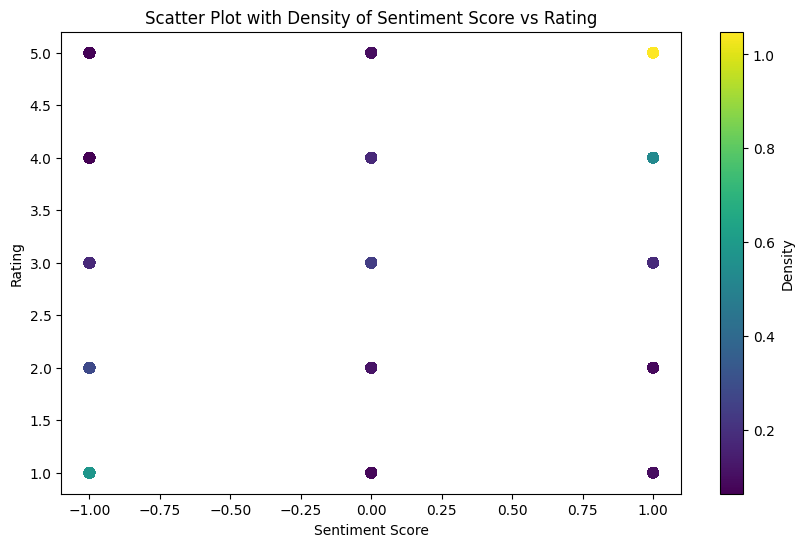

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(game_data_sample_with_sentiment['sentiment_score'], game_data_sample_with_sentiment['rating'], c=z, s=50, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('Sentiment Score')
plt.ylabel('Rating')
plt.title('Scatter Plot with Density of Sentiment Score vs Rating')
plt.show()

In [ ]:
# Calculate proportions of each sentiment score
proportions = game_data_sample_with_sentiment['sentiment_score'].value_counts(normalize=True)
print(proportions)

sentiment_score
 1.0    0.5075
-1.0    0.3070
 0.0    0.1855
Name: proportion, dtype: float64


In [ ]:
# Task 2

In [ ]:
game_data_sample_with_sentiment['review_length'] = game_data_sample_with_sentiment['review'].apply(lambda x: len(x.split()))

In [ ]:
game_data_sample_with_sentiment.head()

,app_package,review,rating,votes,date,uid,formated_date,unix_timestamp,app_category,sentiment_score,review_length
0,com.cleverapps.heroes,It's really a fun game,5,1,"October 21, 2018",shqoc6X1fcJRLEmx,2018-10-21,1.540094e+09,Casual,1,5
1,com.outfit7.mytalkingangelafree,I really love your updated version. it's. bett...,5,718,"August 3, 2019",smlNgCSD1z66dtpP,2019-08-03,1.564805e+09,Casual,1,48
2,com.playhardlab.herofactory,Very good but the fary is a bit annoying,4,0,"April 2, 2022",smnwlsh9CjgHk8Ul,2022-04-02,1.648872e+09,Simulation,1,9
3,com.jumpgames.RealSteel,Bad game ever I want my money back,1,0,"October 10, 2019",snCCzP0FvzSb0p8A,2019-10-10,1.570680e+09,Action,-1,8
4,com.szckhd.jwgly.azyw,Problem resolved.,4,2,"July 29, 2020",snCCzP0FvzSb0p8A,2020-07-29,1.595995e+09,Role Playing,-1,2


In [ ]:
  correlation = game_data_sample_with_sentiment['review_length'].corr(game_data_sample_with_sentiment['sentiment_score'])
print("Correlation between review length and sentiment score:", correlation)

Correlation between review length and sentiment score: -0.17825439773553273


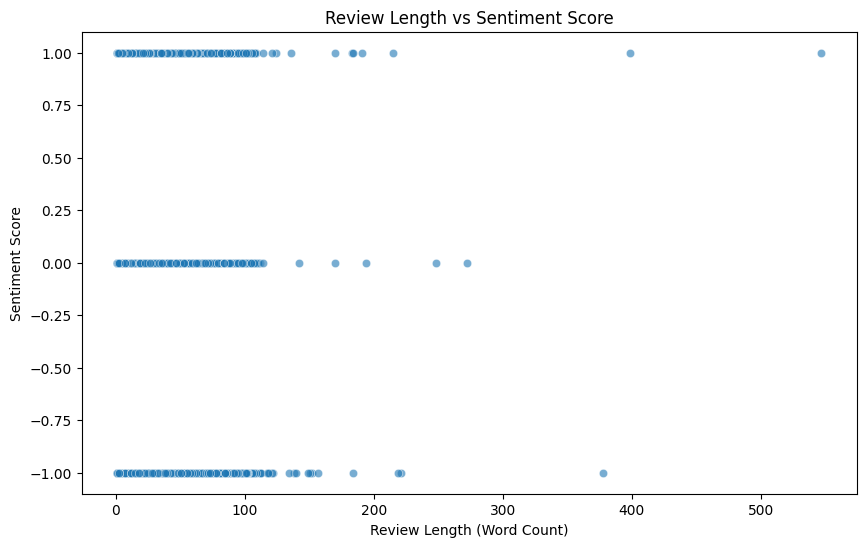

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=game_data_sample_with_sentiment, x='review_length', y='sentiment_score', alpha=0.6)
plt.title('Review Length vs Sentiment Score')
plt.xlabel('Review Length (Word Count)')
plt.ylabel('Sentiment Score')
plt.show()


In [ ]:
# Task 6

In [ ]:
correlation_star_sentiment = game_data_sample_with_sentiment['rating'].corr(game_data_sample_with_sentiment['sentiment_score'])
print("Correlation between star ratings and sentiment scores:", correlation_star_sentiment)

Correlation between star ratings and sentiment scores: 0.6583353327905727


In [ ]:
high_rating_negative_sentiment = game_data_sample_with_sentiment[(game_data_sample_with_sentiment['rating'] >= 4) & (game_data_sample_with_sentiment['sentiment_score'] == -1)]
low_rating_positive_sentiment = game_data_sample_with_sentiment[(game_data_sample_with_sentiment['rating'] <= 2) & (game_data_sample_with_sentiment['sentiment_score'] == 1)]

print("High Rating but Negative Sentiment:\n", high_rating_negative_sentiment)
print("Low Rating but Positive Sentiment:\n", low_rating_positive_sentiment)


High Rating but Negative Sentiment:
                                             app_package  \
4                                 com.szckhd.jwgly.azyw   
55                                          com.dc.hwsj   
75                            com.techvision.restaurant   
157                         com.computerlunch.evolution   
165                 com.gameloft.android.ANMP.GloftA3HM   
...                                                 ...   
13754                       com.pockettrend.neomonsters   
13830                      com.tomtominc.candiesncurses   
13836  com.budgestudios.googleplay.PawPatrolRescueWorld   
13881              sk.inlogic.hillzombieracingearntodie   
13970                       com.pockettrend.neomonsters   

                                                  review  rating  votes  \
4                                      Problem resolved.       4      2   
55     It is a beautiful game and very addictive. How...       4    385   
75     This game is less stre

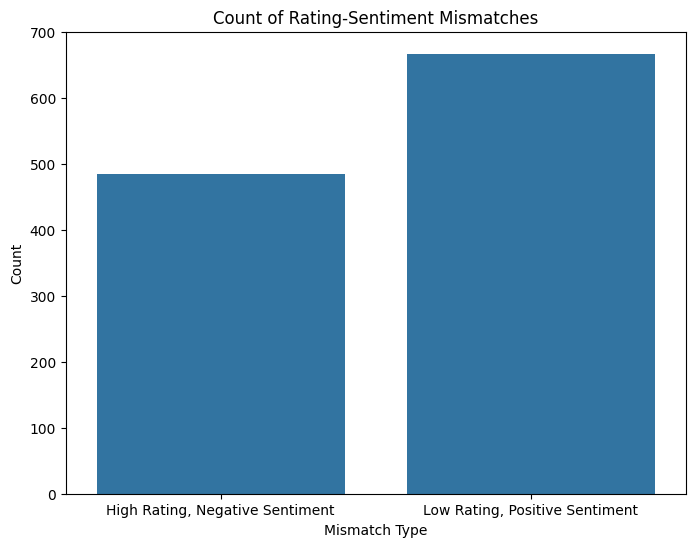

In [ ]:
# Create columns for mismatch categories
game_data_sample_with_sentiment['high_rating_negative_sentiment'] = ((game_data_sample_with_sentiment['rating'] >= 4) & (game_data_sample_with_sentiment['sentiment_score'] == -1)).astype(int)
game_data_sample_with_sentiment['low_rating_positive_sentiment'] = ((game_data_sample_with_sentiment['rating'] <= 2) & (game_data_sample_with_sentiment['sentiment_score'] == 1)).astype(int)

# Plotting
mismatch_counts = {
    'High Rating, Negative Sentiment': game_data_sample_with_sentiment['high_rating_negative_sentiment'].sum(),
    'Low Rating, Positive Sentiment': game_data_sample_with_sentiment['low_rating_positive_sentiment'].sum()
}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(mismatch_counts.keys()), y=list(mismatch_counts.values()))
plt.title('Count of Rating-Sentiment Mismatches')
plt.ylabel('Count')
plt.xlabel('Mismatch Type')
plt.show()


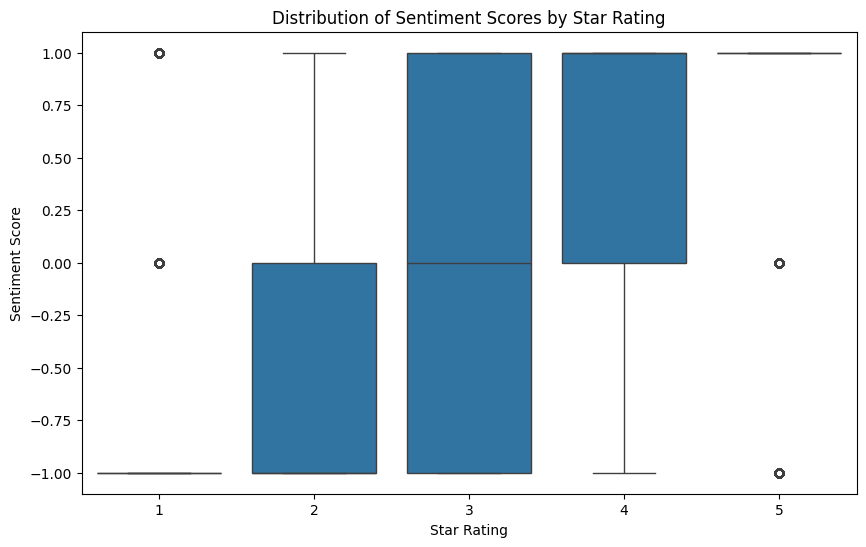

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=game_data_sample_with_sentiment, x='rating', y='sentiment_score')
plt.title('Distribution of Sentiment Scores by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Score')
plt.show()


In [7]:
# Task 1

In [8]:
meta_data = pd.read_csv('/content/drive/MyDrive/DOCUMENTS_COLLEGE/Internships/Samsung_PRISM/Mobile_rec_dataset/app_meta.csv')

In [10]:
print(meta_data.shape)
print(meta_data.columns)
print(meta_data.head(5))

(10173, 9)
Index(['app_package', 'app_name', 'developer_name', 'app_category',
       'description', 'content_rating', 'num_reviews', 'price', 'avg_rating'],
      dtype='object')
                    app_package  \
0            com.natewren.lines   
1  com.capitalone.credittracker   
2        com.purascents.android   
3        com.wallethub.mywallet   
4        air.com.samuramu.gg.se   

                                            app_name  \
0                              Lines Pro - Icon Pack   
1                        CreditWise from Capital One   
2                   Pura - Smart Fragrance Dispenser   
3  WalletHub - Free Credit Score, Report & Monito...   
4            #SelfLove (GG Confidence & Self esteem)   

              developer_name     app_category  \
0           Nate Wren Design  Personalization   
1  Capital One Services, LLC          Finance   
2                       Pura     House & Home   
3                  WalletHub          Finance   
4                 Ggtude Lt

In [11]:
# Merge datasets on 'app_package' to bring avg_rating to game_data_sample_with_sentiment
merged_data = game_data_sample_with_sentiment.merge(meta_data[['app_package', 'avg_rating']], on='app_package', how='left')

In [12]:
# Group by 'app_package' and calculate the average sentiment score
app_sentiment_avg = merged_data.groupby('app_package')['sentiment_score'].mean().reset_index()
app_sentiment_avg.columns = ['app_package', 'avg_sentiment_score']

# Merge average sentiment scores back with app meta data to access avg_rating
app_sentiment_with_rating = app_sentiment_avg.merge(meta_data[['app_package', 'avg_rating']], on='app_package')


In [13]:
# Calculate Pearson correlation between avg_sentiment_score and avg_rating
correlation = app_sentiment_with_rating['avg_sentiment_score'].corr(app_sentiment_with_rating['avg_rating'])
print(f"Pearson correlation between average sentiment score and average app rating: {correlation}")


Pearson correlation between average sentiment score and average app rating: 0.10358224072684423


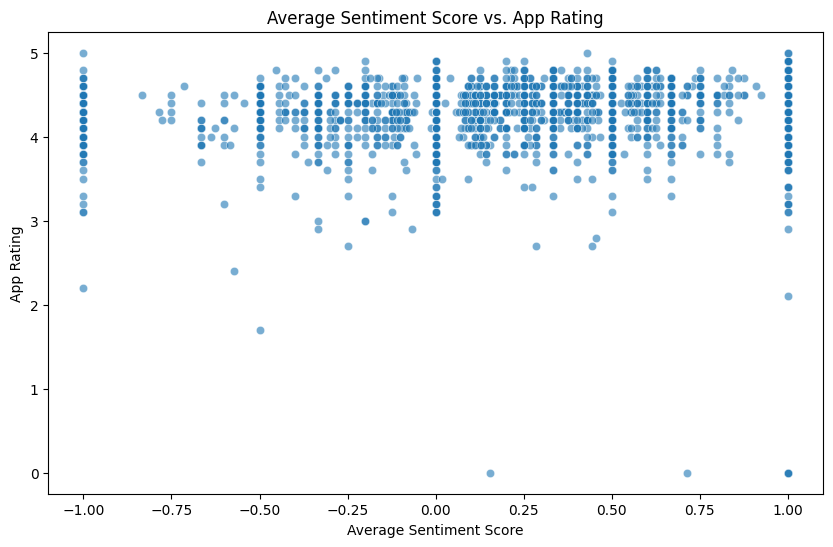

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=app_sentiment_with_rating, x='avg_sentiment_score', y='avg_rating', alpha=0.6)
plt.title('Average Sentiment Score vs. App Rating')
plt.xlabel('Average Sentiment Score')
plt.ylabel('App Rating')
plt.show()
